# Food-101: Entrenamiento del Modelo v2 (CNN desde cero)

In [1]:
# Imports
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [2]:
# Parametros basicos
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES_TO_USE = 5  # CAMBIAR ESTO: 5, 10, 20, 50, 75, 101
AUTOTUNE = tf.data.AUTOTUNE 

if NUM_CLASSES_TO_USE <= 10:
    EPOCHS = 15  
elif NUM_CLASSES_TO_USE <= 20:
    EPOCHS = 15 
elif NUM_CLASSES_TO_USE <= 50:
    EPOCHS = 20
else:
    EPOCHS = 25

print(f'Clases a usar: {NUM_CLASSES_TO_USE}')
print(f'Épocas: {EPOCHS}')
print(f'Batch size: {BATCH_SIZE}')

Clases a usar: 5
Épocas: 15
Batch size: 32


### 1. Cargar datos y crear pipeline

In [4]:
# Cargar Food-101 dataset
(train_ds, val_ds), info = tfds.load(
    'food101',
    split=['train', 'validation'],
    with_info=True,
    as_supervised=True
)

class_names = info.features['label'].names
print(f'Dataset completo cargado: {len(class_names)} clases')

if NUM_CLASSES_TO_USE < 101:    
    train_ds = train_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE) 
    val_ds = val_ds.filter(lambda img, label: label < NUM_CLASSES_TO_USE)
    
    num_classes = NUM_CLASSES_TO_USE
    class_names = class_names[:NUM_CLASSES_TO_USE]
    
    print(f'Clases seleccionadas: {class_names}')
else:
    num_classes = len(class_names)
    print(f'\nUsando TODAS las {num_classes} clases')

print(f'\nTotal clases en uso: {num_classes}')

Dataset completo cargado: 101 clases
Clases seleccionadas: ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

Total clases en uso: 5


In [5]:
def preprocess(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image, training=True)
    return image, label

In [7]:
train_dataset = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [8]:
for images, labels in train_dataset.take(1):
    print(f'Batch de imagenes: {images.shape}')
    print(f'Batch de labels: {labels.shape}')
    print(f'Rango de valores: [{tf.reduce_min(images):.2f}, {tf.reduce_max(images):.2f}]')

Batch de imagenes: (32, 224, 224, 3)
Batch de labels: (32,)
Rango de valores: [0.00, 1.00]


### 2. Crear modelo (CNN desde cero)

**Arquitectura personalizada:**
- 4 bloques convolucionales (32 → 64 → 128 → 256 filtros)
- MaxPooling después de cada bloque para reducir dimensionalidad
- Dropout para regularización y prevenir overfitting
- Capa densa final con softmax para clasificación
- ~600k parámetros entrenables (vs 2.2M en MobileNetV2)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,865,445 (102.48 MB)

 Trainable params: 26,865,445 (102.48 MB)

 Non-trainable params: 0 (0.00 B)

### 3. Compilar y entrenar

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/15
    118/Unknown 123s 922ms/step - accuracy: 0.1930 - loss: 1.6987

/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


118/118 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.1930 - loss: 1.6981 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 674ms/step - accuracy: 0.1951 - loss: 1.6099 - val_accuracy: 0.2000 - val_loss: 1.6095
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 676ms/step - accuracy: 0.2089 - loss: 1.6095 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 672ms/step - accuracy: 0.2047 - loss: 1.6096 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 82s 690ms/step - accuracy: 0.1877 - loss: 1.6098 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 80s 675ms/step - accuracy: 0.1910 - loss: 1.6094 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 78s 655ms/step - accuracy: 0.1875 - loss: 1.6098 - val_accuracy: 0.2000 - val_loss: 1.6094
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 77s 649ms/step - accuracy: 0.1980 - loss: 1.6095 - val_a

### 4. Visualizar entrenamiento

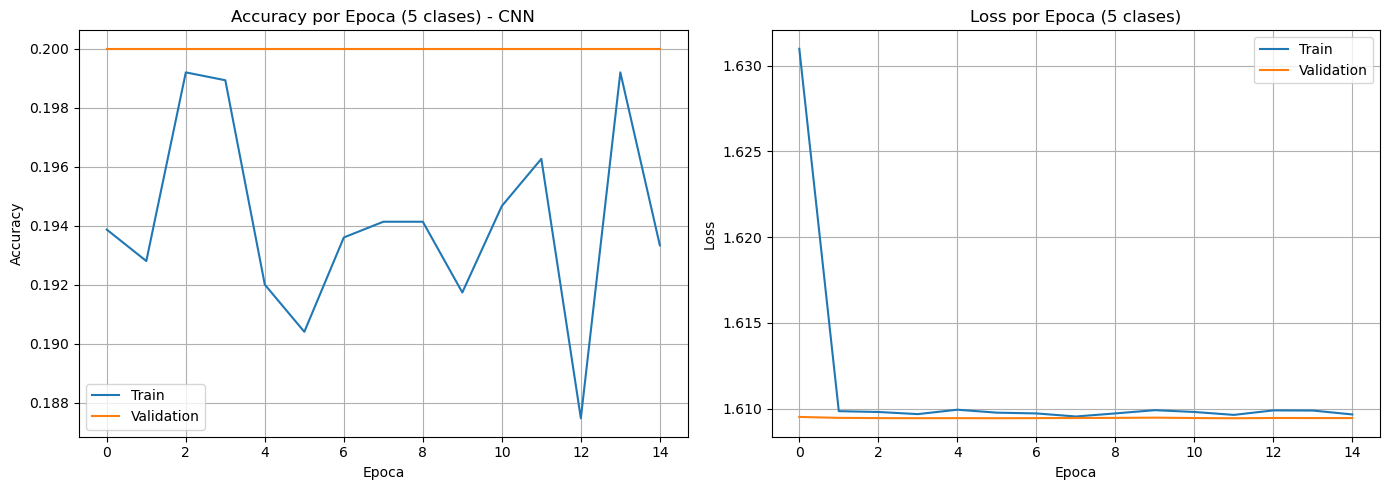

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title(f'Accuracy por Epoca ({NUM_CLASSES_TO_USE} clases) - CNN')
ax1.set_xlabel('Epoca')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title(f'Loss por Epoca ({NUM_CLASSES_TO_USE} clases)')
ax2.set_xlabel('Epoca')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

### 5. Evaluar modelo en validacion

In [13]:
test_loss, test_acc = model.evaluate(val_dataset)
print(f'\nValidation Loss: {test_loss:.4f}')
print(f'Validation Accuracy: {test_acc:.4f}')
print(f'\nMejora sobre random (1/{num_classes}): {test_acc / (1/num_classes):.1f}x')

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 0.1809 - loss: 1.6097

Validation Loss: 1.6095
Validation Accuracy: 0.2000

Mejora sobre random (1/5): 1.0x


In [14]:
y_true = []
y_pred = []

for images, labels in val_dataset:
    predictions = model.predict(images, verbose=0) 
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(f'Predicciones generadas: {len(y_pred)}')

Predicciones generadas: 1250


### 6. Analizar resultados (Confusion Matrix)

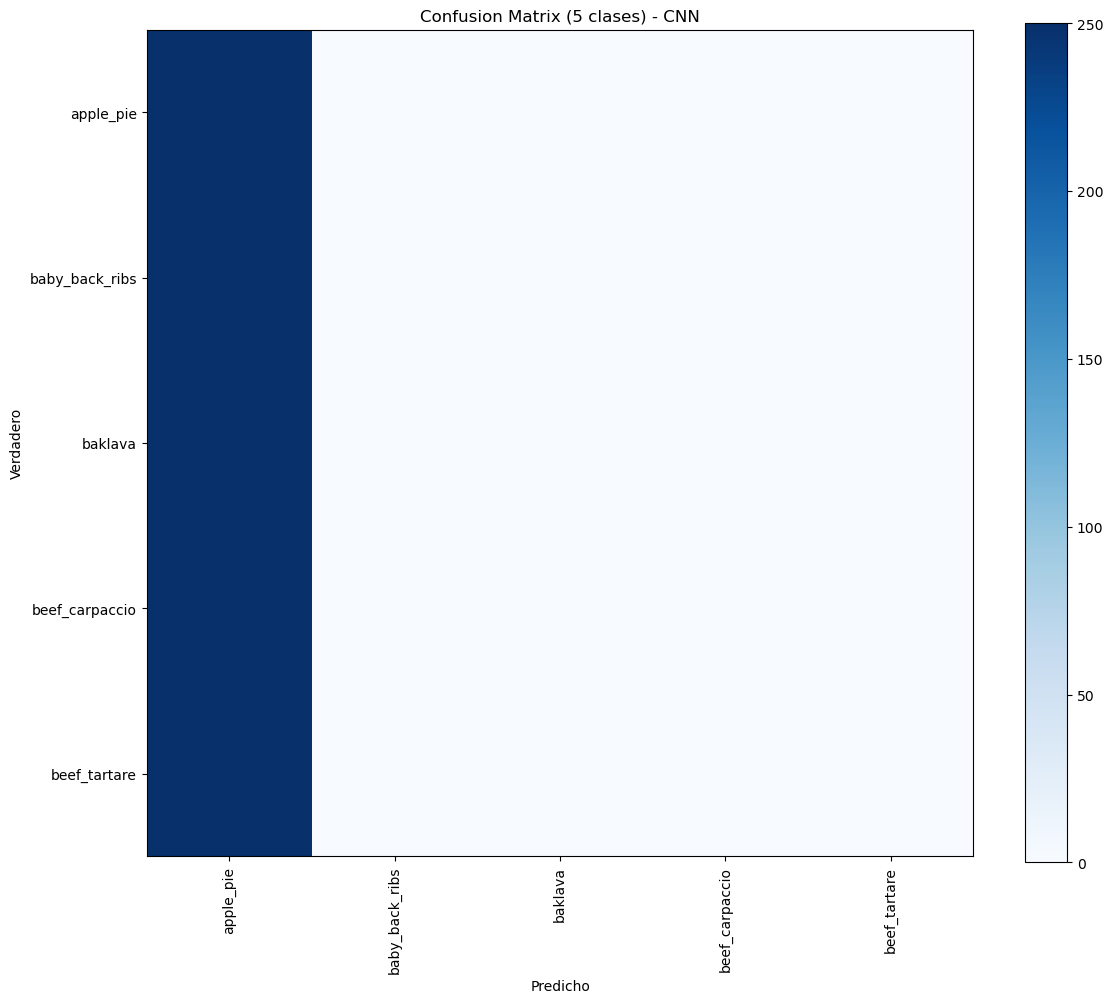

In [16]:
display_n = num_classes if num_classes <= 20 else 20
mask = (y_true < display_n) & (y_pred < display_n)
y_true_display = y_true[mask]
y_pred_display = y_pred[mask]

cm = confusion_matrix(y_true_display, y_pred_display, labels=range(display_n))

plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title(f'Confusion Matrix ({display_n} clases) - CNN')
plt.colorbar()
tick_marks = np.arange(display_n)
plt.xticks(tick_marks, [class_names[i][:15] for i in range(display_n)], rotation=90)
plt.yticks(tick_marks, [class_names[i][:15] for i in range(display_n)])
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

In [17]:
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    digits=3
)

print(report)

                precision    recall  f1-score   support

     apple_pie      0.200     1.000     0.333       250
baby_back_ribs      0.000     0.000     0.000       250
       baklava      0.000     0.000     0.000       250
beef_carpaccio      0.000     0.000     0.000       250
  beef_tartare      0.000     0.000     0.000       250

      accuracy                          0.200      1250
     macro avg      0.040     0.200     0.067      1250
  weighted avg      0.040     0.200     0.067      1250



/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

### 7. Visualizar predicciones

In [18]:
sample_images = []
sample_labels = []
sample_predictions = []

for images, labels in val_dataset.take(3):
    predictions = model.predict(images, verbose=0)
    sample_images.extend(images.numpy())
    sample_labels.extend(labels.numpy())
    sample_predictions.extend(np.argmax(predictions, axis=1))

correct_indices = [i for i in range(len(sample_labels)) if sample_labels[i] == sample_predictions[i]]
incorrect_indices = [i for i in range(len(sample_labels)) if sample_labels[i] != sample_predictions[i]]

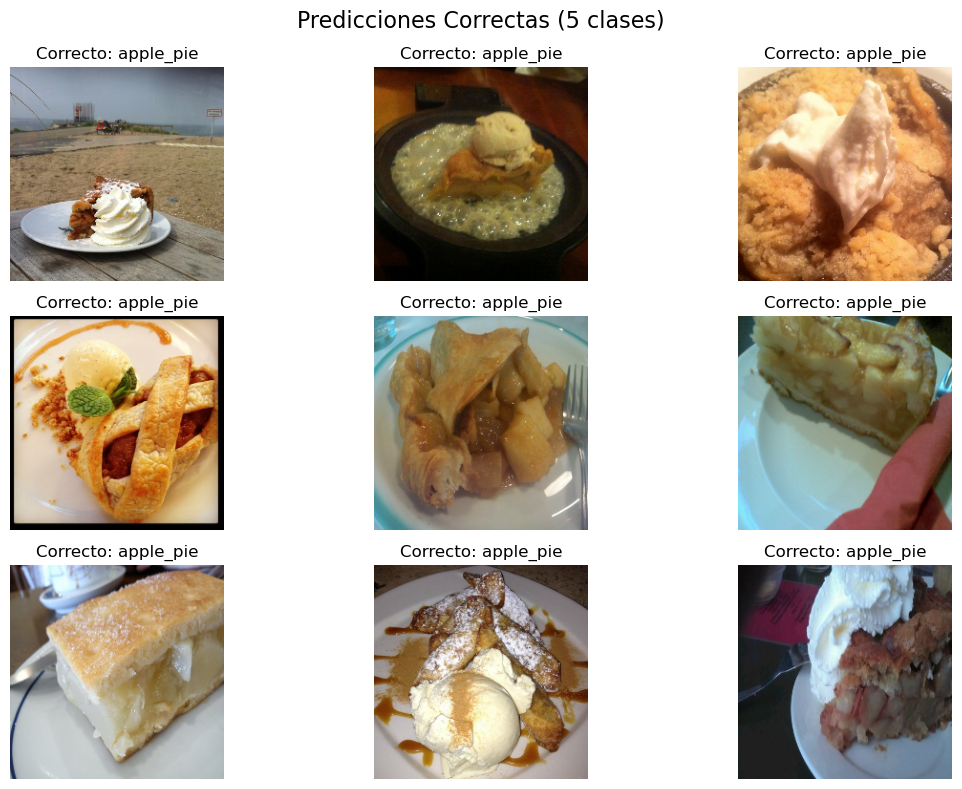

In [20]:
plt.figure(figsize=(12, 8))
for i in range(min(9, len(correct_indices))):
    idx = correct_indices[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[idx])
    plt.title(f'Correcto: {class_names[sample_labels[idx]][:15]}')
    plt.axis('off')
plt.suptitle(f'Predicciones Correctas ({NUM_CLASSES_TO_USE} clases)', fontsize=16)
plt.tight_layout()
plt.show()

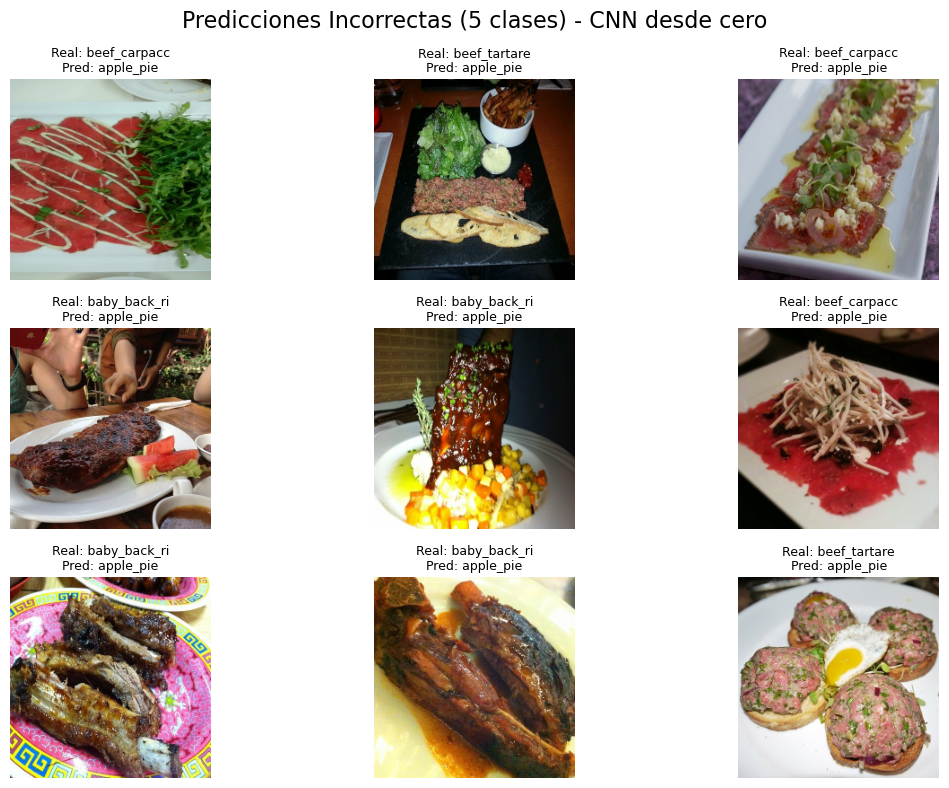

In [21]:
if len(incorrect_indices) > 0:
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(incorrect_indices))):
        idx = incorrect_indices[i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(sample_images[idx])
        plt.title(f'Real: {class_names[sample_labels[idx]][:12]}\nPred: {class_names[sample_predictions[idx]][:12]}', 
                  fontsize=9)
        plt.axis('off')
    plt.suptitle(f'Predicciones Incorrectas ({NUM_CLASSES_TO_USE} clases) - CNN desde cero', fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print('No hay predicciones incorrectas en la muestra')

### 8. Guardar todo (modelo + resultados)

In [22]:
model_name = f'models/food_model_v2_fromscratch_{NUM_CLASSES_TO_USE}classes.keras'
model.save(model_name)
print(f'Modelo guardado en: {model_name}')

Modelo guardado en: models/food_model_v2_fromscratch_5classes.keras


In [23]:
import os
results_dir = f'results/v2_fromscratch_{NUM_CLASSES_TO_USE}classes'
os.makedirs(results_dir, exist_ok=True)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{results_dir}/training_history.csv', index=False)
print(f'Historial guardado en: {results_dir}/training_history.csv')

Historial guardado en: results/v2_fromscratch_5classes/training_history.csv


In [24]:
cm_full = confusion_matrix(y_true, y_pred, labels=range(num_classes))
cm_df = pd.DataFrame(cm_full, index=class_names, columns=class_names)
cm_df.to_csv(f'{results_dir}/confusion_matrix_full.csv')
print(f'Confusion matrix guardada en: {results_dir}/confusion_matrix_full.csv')

with open(f'{results_dir}/classification_report.txt', 'w') as f:
    f.write(report)
print(f'Classification report guardado en: {results_dir}/classification_report.txt')

Confusion matrix guardada en: results/v2_fromscratch_5classes/confusion_matrix_full.csv
Classification report guardado en: results/v2_fromscratch_5classes/classification_report.txt


## 9. Resumen final

In [29]:
print(f'Dataset: Food-101 ({num_classes} clases)')
print(f'Epocas: {EPOCHS}')
print(f'Batch size: {BATCH_SIZE}')
print(f'\nResultados:')
print(f'  Training Accuracy:   {history.history["accuracy"][-1]:.4f}')
print(f'  Validation Accuracy: {test_acc:.4f}')
print(f'  Training Loss:       {history.history["loss"][-1]:.4f}')
print(f'  Validation Loss:     {test_loss:.4f}')
print(f'\nMejora sobre random: {test_acc / (1/num_classes):.1f}x')

Dataset: Food-101 (5 clases)
Epocas: 15
Batch size: 32

Resultados:
  Training Accuracy:   0.1933
  Validation Accuracy: 0.2000
  Training Loss:       1.6097
  Validation Loss:     1.6095

Mejora sobre random: 1.0x
